# Dataquest Guided Project: Credit Card Customer Segmentation

**Purpose:** In this scenario, I am working for a credit card company. I have data containing information about the company's clients, and I'm tasked with segmenting them into different groups in order to apply different business strategies to different types of customers.

## Import Libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sns.set_style("white")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## Preview Data
* Our data has 10,127 rows and 14 columns.
* Our data is quite clean! We don't have missing values, the data types look correct, and none of the values look incorrect/improbable. 
    * We do have some categorical columns that we'll have to convert to numeric.

Data Dictionary:
1. `customer_id`: unique identifier for each customer.
2. `age`: customer age in years.
3. `gender`: customer gender (M or F).
4. `dependent_count`: number of dependents of each customer.
5. `education_level`: level of education ("High School", "Graduate", etc.).
6. `marital_status`: marital status ("Single", "Married", etc.).
7. `estimated_income`: the estimated income for the customer projected by the data science team.
8. `months_on_book`: time as a customer in months.
9. `total_relationship_count`: number of times the customer contacted the company.
10. `months_inactive_12_mon`: number of months the customer did not use the credit card in the last 12 months.
11. `credit_limit`: customer's credit limit.
12. `total_trans_amount`: the overall amount of money spent on the card by the customer.
13. `total_trans_count`: the overall number of times the customer used the card.
14. `avg_utilization_ratio`: daily average utilization ratio.


In [2]:
customer_data = pd.read_csv('customer_segmentation.csv')
customer_data.shape

(10127, 14)

In [6]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

In [5]:
customer_data.describe()

,customer_id,age,dependent_count,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,62078.206774,35.928409,3.812580,2.341167,8631.953698,4404.086304,64.858695,0.274894
std,3.690378e+07,8.016814,1.298908,39372.861291,7.986416,1.554408,1.010622,9088.776650,3397.129254,23.472570,0.275691
min,7.080821e+08,26.000000,0.000000,20000.000000,13.000000,1.000000,0.000000,1438.300000,510.000000,10.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,32000.000000,31.000000,3.000000,2.000000,2555.000000,2155.500000,45.000000,0.023000
50%,7.179264e+08,46.000000,2.000000,50000.000000,36.000000,4.000000,2.000000,4549.000000,3899.000000,67.000000,0.176000
75%,7.731435e+08,52.000000,3.000000,80000.000000,40.000000,5.000000,3.000000,11067.500000,4741.000000,81.000000,0.503000
max,8.283431e+08,73.000000,5.000000,200000.000000,56.000000,6.000000,6.000000,34516.000000,18484.000000,139.000000,0.999000


In [25]:
customer_data['gender'].value_counts()
customer_data['education_level'].value_counts()
customer_data['marital_status'].value_counts()

F    5358
M    4769
Name: gender, dtype: int64

Graduate         3685
High School      2351
Uneducated       1755
College          1192
Post-Graduate     616
Doctorate         528
Name: education_level, dtype: int64

Married     4687
Single      3943
Unknown      749
Divorced     748
Name: marital_status, dtype: int64

We can start to observe some initial correlations:
* Age is related to months on book.
* Credit limit is positively related to income and negatively related to utilization ratio.
* Total transaction amount is related to total transaction count.

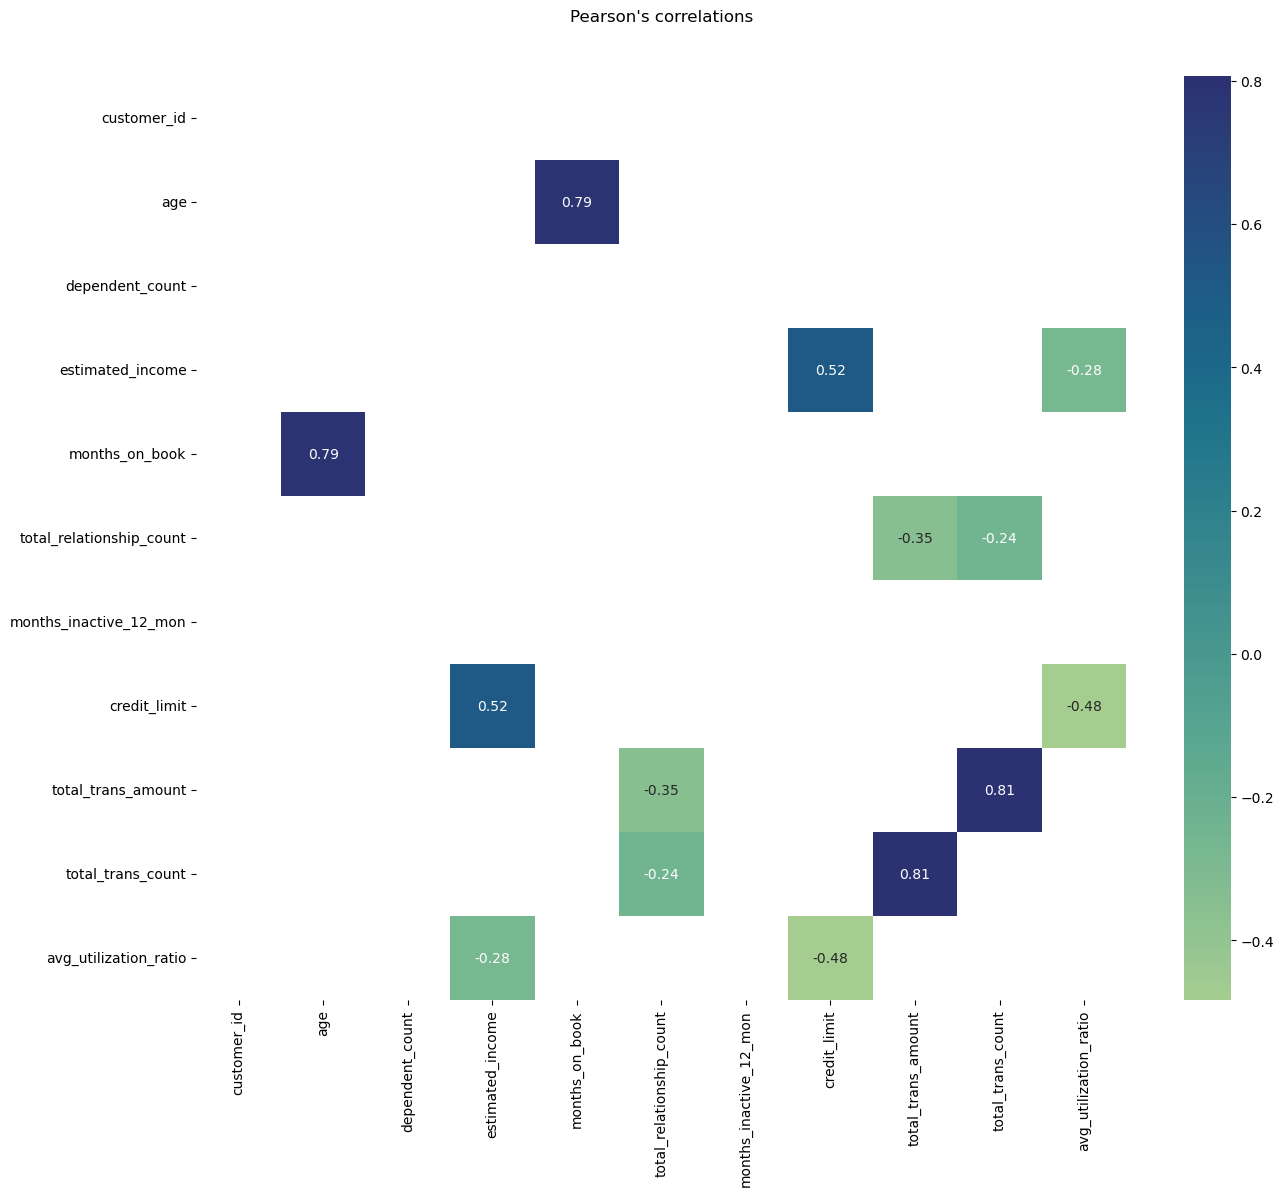

In [17]:
#create pearson correlation heatmap of features
corrs = customer_data.corr()

#only show corrs between .2 and 1 for readability (corr = 1 is just self correlation)
plt.figure(figsize=(15,12))
sns.heatmap(corrs[(corrs<-0.2) | ((corrs>0.2)&(corrs<1))], cmap='crest', annot=True)
plt.title("Pearson's correlations", y = 1.05);

Now let's review the distributions for our numeric variables.
* Credit limit, income, and transaction amount are right skewed.
* Credit limit tends to sit below 20%.
* Median income is $50k with a max of around $200k.
* Months on book is relatively symmetrical, with a median value around 36 months.
* Median transaction amount is $5k, quickly tapering off as amount increases; max transaction is $20k.
* Age is relatively normally distributed, with the majority of customers being between 35 and 55.

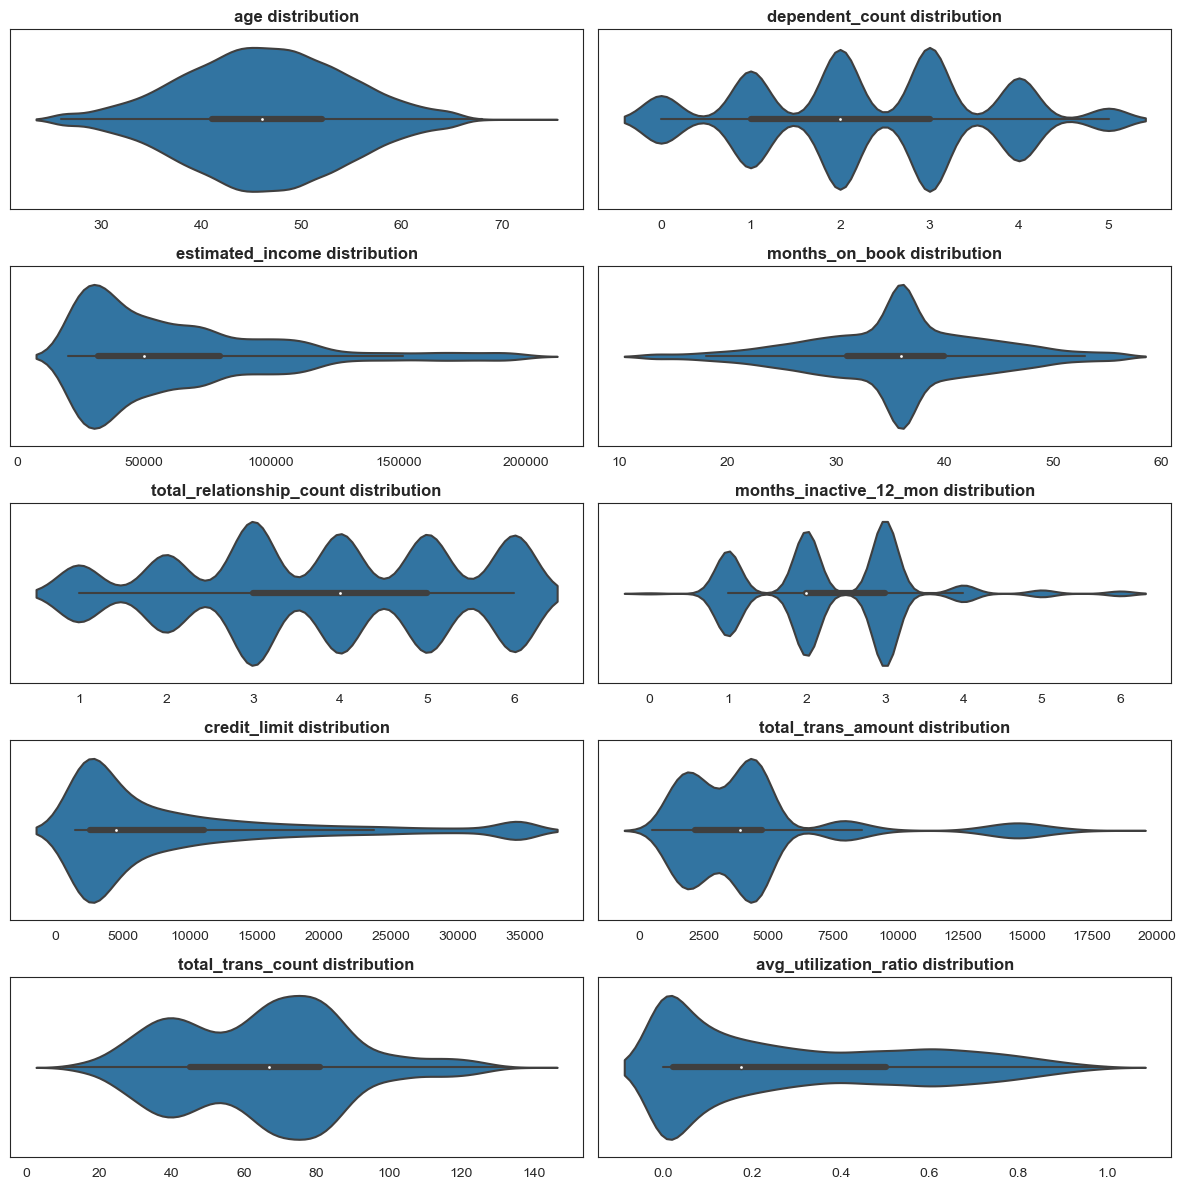

In [22]:
num_cols = ['age','dependent_count', 'estimated_income', 'months_on_book', 'total_relationship_count',
            'months_inactive_12_mon', 'credit_limit', 'total_trans_amount', 'total_trans_count', 
            'avg_utilization_ratio']
fig = plt.figure(figsize=(12, 12))
for i, col in enumerate(num_cols):
    plt.subplot(5,2,i+1)
    sns.violinplot(data=customer_data, x=col)
    plt.title(f'{col} distribution', weight='bold')
    plt.xlabel('')
plt.tight_layout()   
plt.show()




## Feature Engineering


In [30]:
#create copy of df
customers_modif = customer_data.copy()

#convert gender to 0s and 1s
customers_modif['gender'] = customers_modif['gender'].apply(lambda x: 1 if x == 'M' else 0)

#convert education_level to numeric
ed_dict = {'Uneducated': 0, 'High School': 1, 'College': 2, 'Graduate': 3, 'Post-Graduate': 4, 'Doctorate': 5}

customers_modif['education_level'] = customers_modif['education_level'].map(ed_dict)

#we'll use one hot encoding for marital status because this variable is not ordinal
#get marital status dummies
marital_dummies=pd.get_dummies(customers_modif['marital_status'], drop_first=False)
#combine with original df
customers_modif=pd.concat([customers_modif, marital_dummies], axis=1)
#drop the original marital status column
customers_modif=customers_modif.drop(columns='marital_status')
#check results
customers_modif.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  int64  
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  int64  
 5   estimated_income          10127 non-null  int64  
 6   months_on_book            10127 non-null  int64  
 7   total_relationship_count  10127 non-null  int64  
 8   months_inactive_12_mon    10127 non-null  int64  
 9   credit_limit              10127 non-null  float64
 10  total_trans_amount        10127 non-null  int64  
 11  total_trans_count         10127 non-null  int64  
 12  avg_utilization_ratio     10127 non-null  float64
 13  Divorced                  10127 non-null  uint8  
 14  Marrie

## Scaling the Data
Our features represent a diverse set of measures, so prior to building our model, we need to transform and scale the features.

In [31]:
#drop id column; not useful for analysis
customer_scaled = customers_modif.drop('customer_id', axis = 1)

#instantiate scaler
scaler = StandardScaler()
#fit the data to the scaler
scaler.fit(customer_scaled)

#scale the data
customer_scaled = scaler.transform(customer_scaled)
#convert back to df
customer_scaled = pd.DataFrame(customer_scaled)


StandardScaler()

## Choosing K
Now that our data is ready for modeling, we need to determine what the appropriate number of clusters is to use in the model. We'll do this by running several models and comparing their inertias.

In [48]:
#inertia list
inertias = []

#look through 20 k values
for k in range(1,11):
    #instantiate model with k clusters
    model = KMeans(n_clusters=k)
    #fit to data
    cluster = model.fit_predict(customer_scaled)
    #append inertia value
    inertias.append(model.inertia_)


c:\Users\maris\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\maris\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\maris\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\maris\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\maris\anaconda3\lib

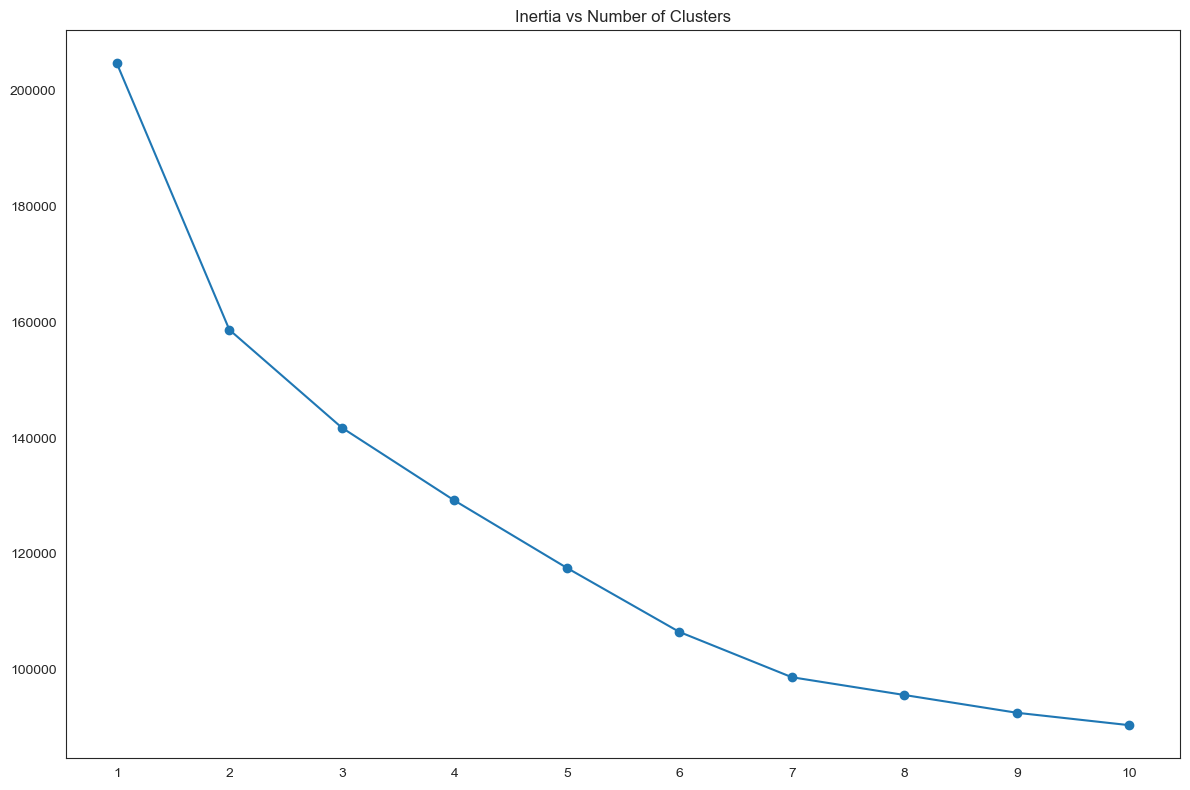

In [50]:
#plot the inertias
plt.figure(figsize=(12, 8))
plt.plot(range(1, 11), inertias, marker='o')
plt.xticks(ticks=range(1, 11), labels=range(1, 11))
plt.title('Inertia vs Number of Clusters')

plt.tight_layout()
plt.show();

Based on the elbow curve, six clusters appears to be a reasonable choice. Let's fit a model using 6 clusters.

In [51]:
 #instantiate model with 6 clusters
model2 = KMeans(n_clusters=6)
#fit to data
cluster2 = model2.fit_predict(customer_scaled)


c:\Users\maris\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


## Analyze Results


3    3296
2    2350
4    2158
1     853
5     735
6     735
Name: Cluster, dtype: int64


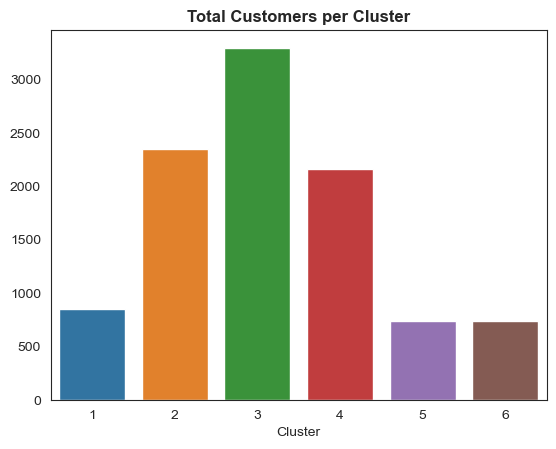

In [52]:
#How many customers in each cluster?
customer_data['Cluster'] = cluster2 + 1
print(customer_data['Cluster'].value_counts())

sns.countplot(data=customer_data, x='Cluster')
plt.title('Total Customers per Cluster', weight='bold')
plt.ylabel('')
plt.show();

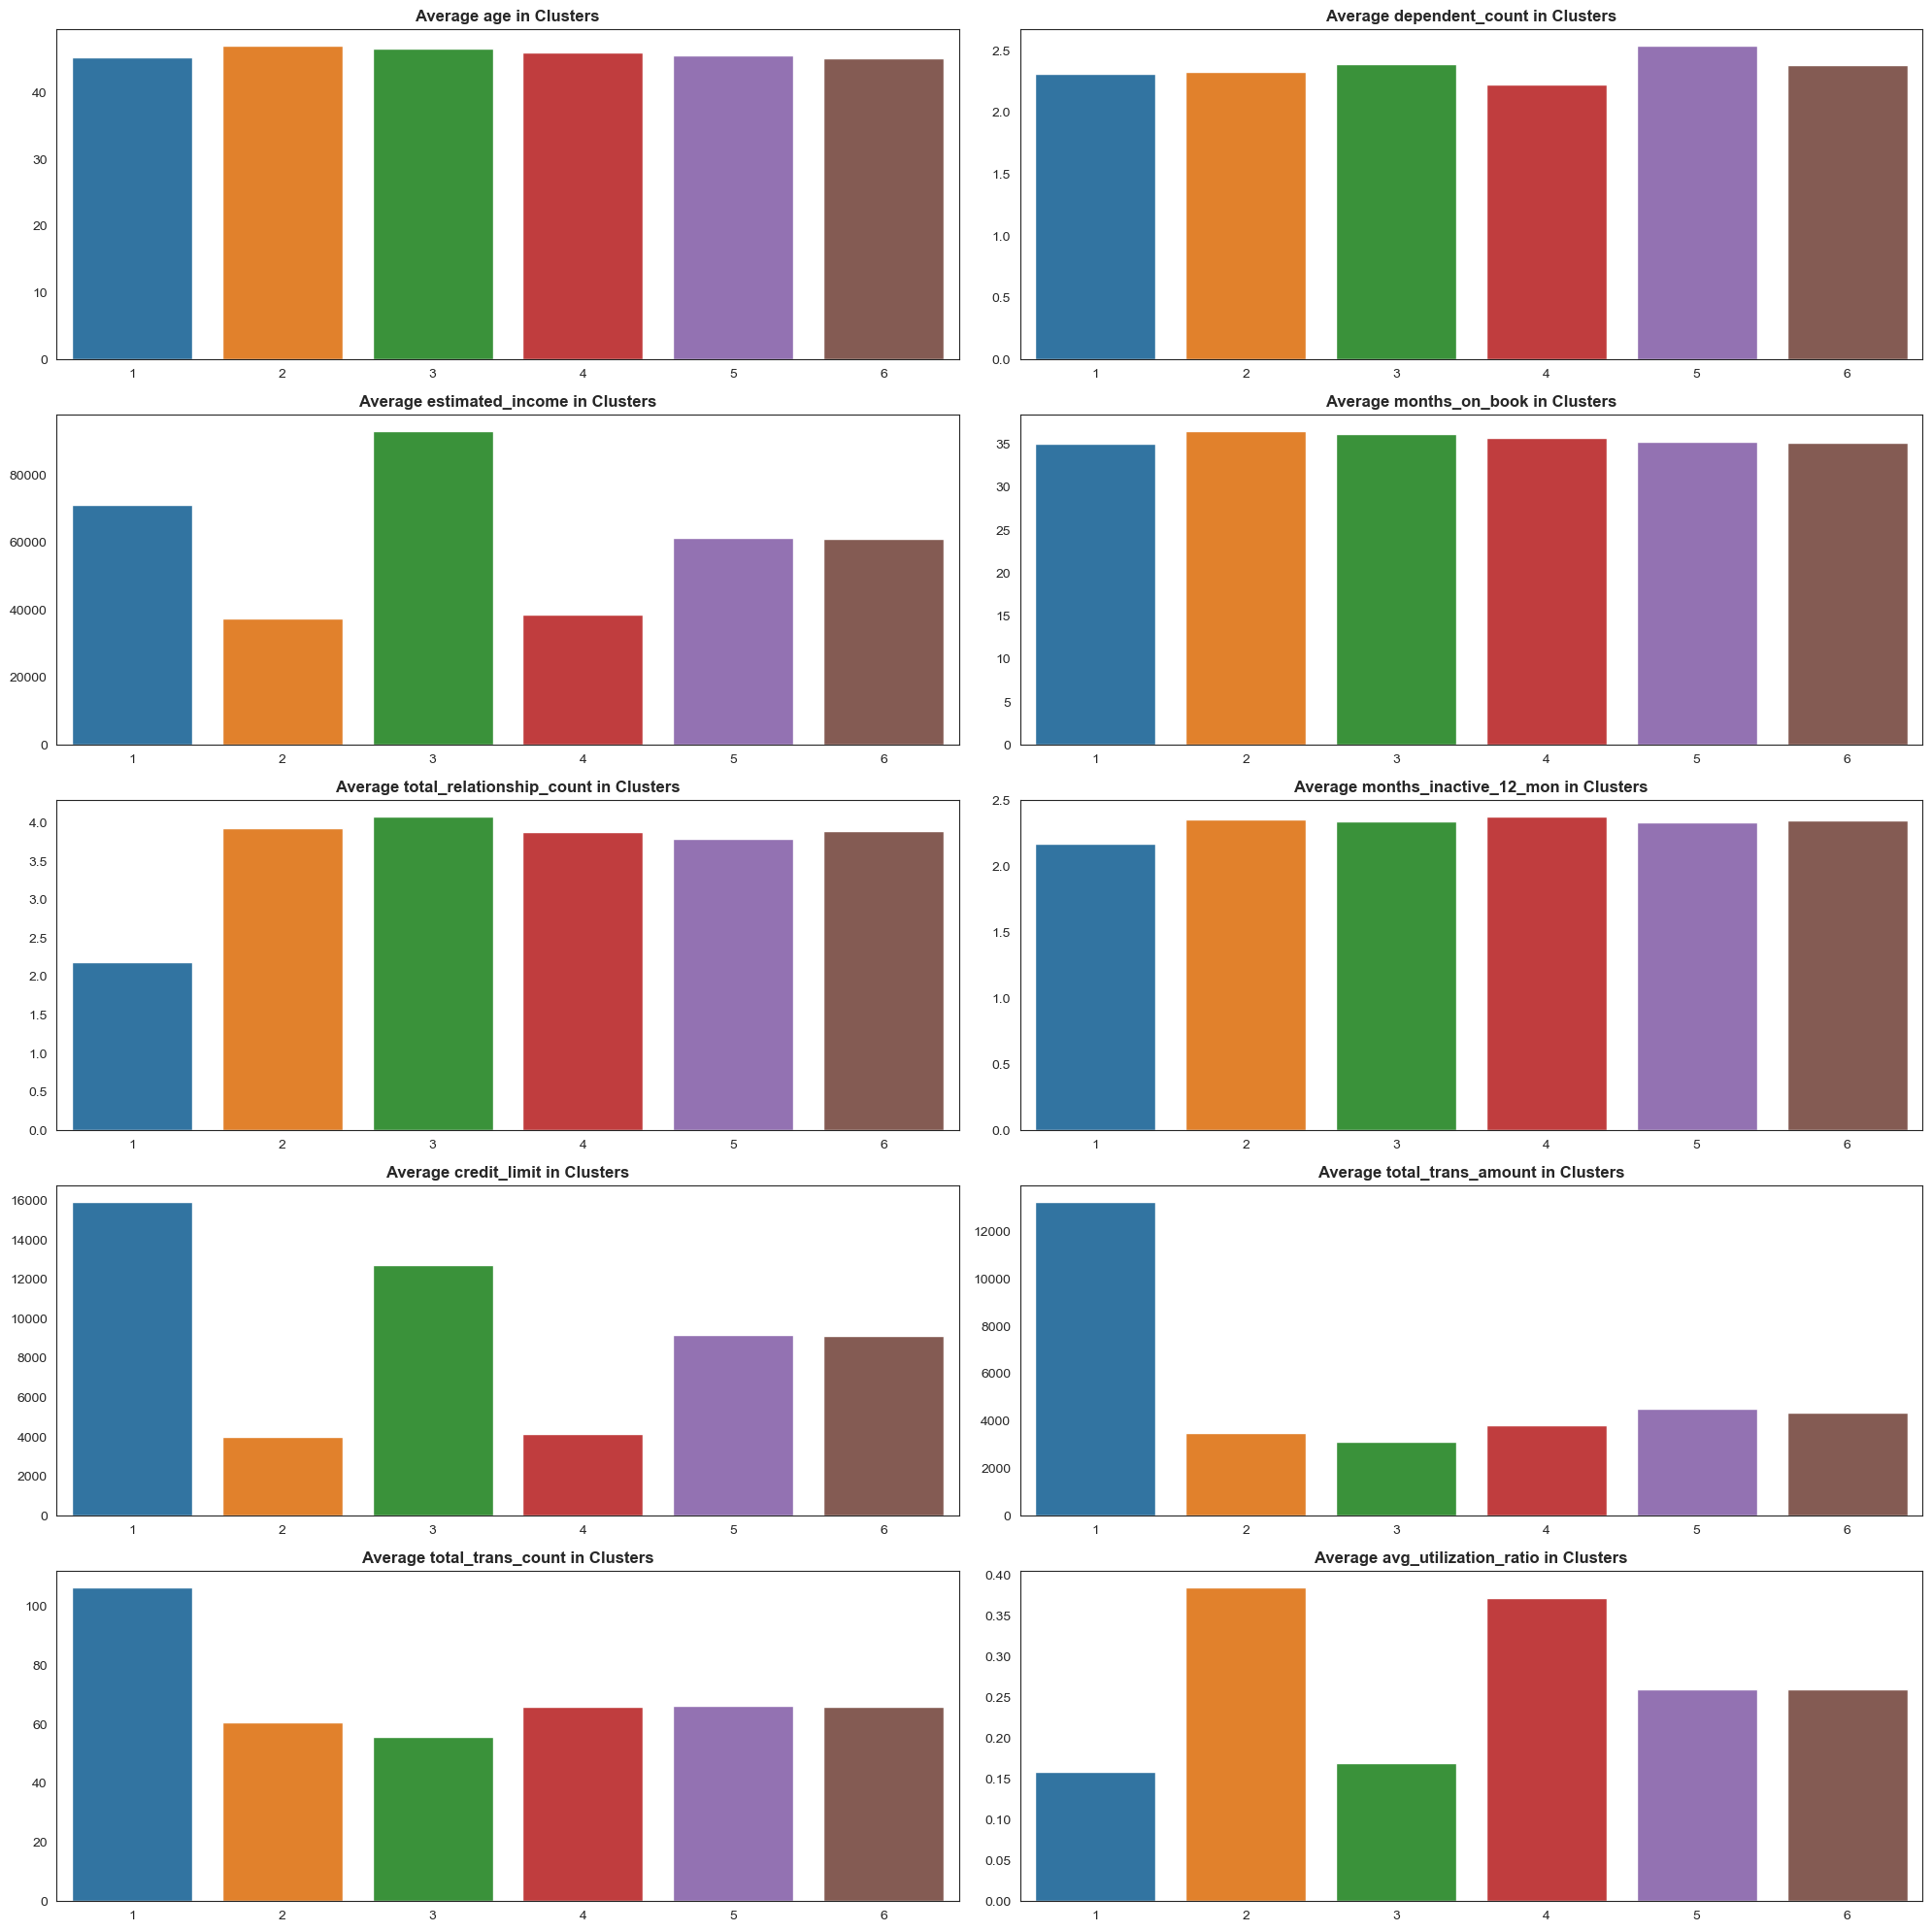

In [53]:
numeric_columns = customer_data.select_dtypes(include=np.number).drop(['customer_id', 'Cluster'], axis=1).columns

plt.figure(figsize=(20,20))

for i, col in enumerate(numeric_columns):
    plt.subplot(5,2,i+1)
    p=sns.barplot(data=customer_data, x='Cluster', y=col, ci=None)
    plt.title(f'Average {col} in Clusters', weight='bold')
    plt.ylabel('')
    plt.xlabel('')
plt.tight_layout()   
plt.show();